# Project 1 Question 2

In this part, we evaluate an American put option. Assume that $T=1$, $S_0=10$, $\mu=5\%$, $\sigma=20\%$, and the risk-free rate $r=2\%$. Use $N=5000$ and a strike $K=10$.

Since the stochastic dynamic for the asset price process is $S_{t_k}=S_{t_{k-1}}e^{r\Delta t+\sigma\sqrt{\Delta t}}$ when $\epsilon_k=+1$, then the up factor is $u=\frac{S_{t_k}}{S_{t_{k-1}}}=e^{r\Delta t+\sigma\sqrt{\Delta t}}$ and the down factor is just $d=\frac{1}{u}$.

For the risk-neutral measure approach, we have $\mathbb{Q}(\epsilon_k=+1)=\frac{e^{r\Delta t} - d}{u - d} = \frac{1 - e^{-\sigma\sqrt{\Delta t}}}{e^{\sigma\sqrt{\Delta t}} - e^{-\sigma\sqrt{\Delta t}}}$

For the real-world measure approach, we have $\mathbb{P}(\epsilon_k=+1)=\frac{1}{2}\left(1+\frac{(\mu - r) - \frac{1}{2}\sigma^2}{\sigma}\sqrt{\Delta t}\right)$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Part (a)

Implement the valuation and exercise boundary of the American put option with $B$ as the numéraire.

### i.

Plot the exercise boundary as a function of $t$.


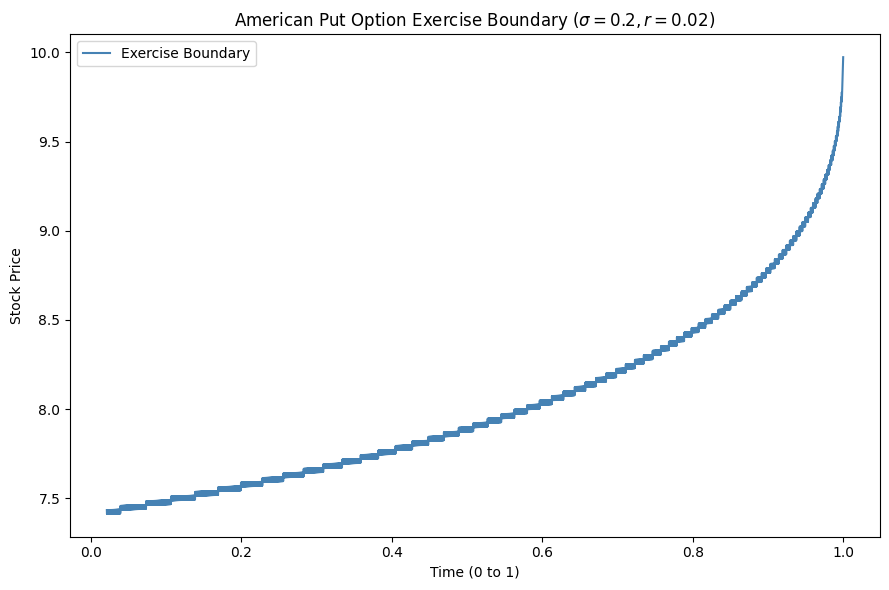

In [3]:
def plot_exercise_boundary(sigma, r, ax, T=1, S0=10, K=10, mu=0.05, N=5000, just_stock_option_tree = False):
    dt = T / N
    time_steps = np.linspace(0, 1, N + 1)
    sqrt_dt = np.sqrt(dt)
    u = np.exp(r * dt + sigma * sqrt_dt)
    d = np.exp(r * dt - sigma * sqrt_dt)

    # Risk-neutral up-branch probability
    p_risk_neutral = (1 - np.exp(-sigma * np.sqrt(dt))) / (
        np.exp(sigma * np.sqrt(dt)) - np.exp(-sigma * np.sqrt(dt))
    )

    p_physical = 0.5 * (1 + ((mu - r) - 0.5 * sigma**2) / sigma * sqrt_dt)

    # Stock
    stock_tree = np.zeros((N + 1, N + 1))
    stock_tree[:, 0] = S0 * d ** np.arange(N + 1)
    for j in range(1, N + 1):
        stock_tree[j, 1:j + 1] = stock_tree[j - 1, :j] * u

    option_value = np.maximum(K - stock_tree, 0)

    discount_factor = np.exp(-r * dt)
    for i in range(N - 1, -1, -1):
        option_value[i, :i + 1] = discount_factor * (
            p_risk_neutral * option_value[i + 1, 1:i + 2]
            + (1 - p_risk_neutral) * option_value[i + 1, :i + 1]
        )
        intrinsic_value = K - stock_tree[i, :i + 1]
        option_value[i, :i + 1] = np.maximum(option_value[i, :i + 1], intrinsic_value)

    if just_stock_option_tree:
        return stock_tree, option_value

    intrinsic_values = K - stock_tree
    exercise_boundary = np.full((N + 1, 2), np.nan)

    for i in range(N + 1):
        optimal_indices = np.where(option_value[i, :i + 1] == intrinsic_values[i, :i + 1])[0]
        if optimal_indices.size > 0:
            exercise_boundary[i] = [time_steps[i], stock_tree[i, optimal_indices[-1]]]

    # Plot the exercise boundary
    ax.plot(exercise_boundary[:, 0],exercise_boundary[:, 1],
            label="Exercise Boundary",
            color="steelblue"
    )
    ax.set_title(f"American Put Option Exercise Boundary ($\sigma={sigma}, r={r}$)")
    ax.set_xlabel("Time (0 to 1)")
    ax.set_ylabel("Stock Price")
    ax.legend()
    return exercise_boundary

# Call the function with a single subplot
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plot_exercise_boundary(sigma=0.2, r=0.02, ax=ax)
plt.tight_layout()
plt.show()


### ii.

Generate two sample paths where in sample path

(1) the option is exercised early (say around $t=\frac{1}{2}$),

(2) the option is not exercised.

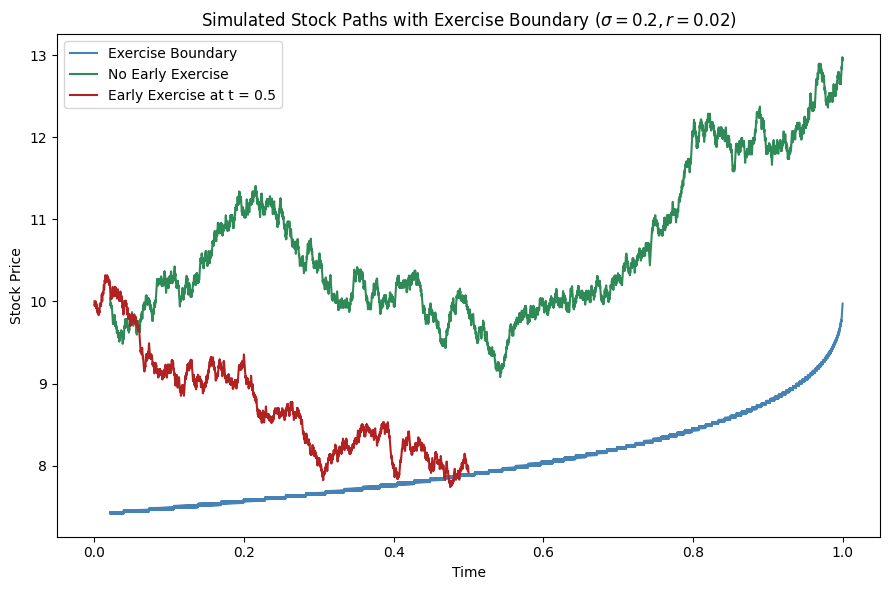

In [4]:
def generate_path(S0, N, u, d, p):
    """
    Generates a single path based on up/down moves.
    """
    path = np.zeros(N + 1)
    path[0] = S0  # Initial stock price

    # Generate path using the provided logic
    for j in range(1, N + 1):
        if np.random.rand() < p:  # Up move
            path[j] = path[j - 1] * u
        else:  # Down move
            path[j] = path[j - 1] * d

    return path

def generate_paths_with_exercise_boundary(sigma, r, ax, T=1, S0=10, K=10, mu=0.05, N=5000, plot=True):
    """
    Generates paths and plots the exercise boundary.
    """

    dt = T / N
    time_steps = np.linspace(0, T, N + 1)
    u = np.exp(r * dt + sigma * np.sqrt(dt))
    d = np.exp(r * dt - sigma * np.sqrt(dt))

    p_physical = 0.5 * (1 + ((mu - r) - 0.5 * sigma**2) / sigma * np.sqrt(dt))

    boundary = plot_exercise_boundary(sigma, r, ax)
    # Simulate Path 1: No early exercise (must stay above boundary)
    path_no_exercise = generate_path(S0, N, u, d, p_physical)
    path_no_exercise = np.maximum(path_no_exercise, boundary[:, 1])
    # Simulate Path 2: Find a path that touches the boundary at t = 0.5 and stops
    path_early_exercise = None
    T_hit = 0.5
    N_hit = int(N * (T_hit / T))
    while path_early_exercise is None:
        candidate_path = generate_path(S0, N_hit, u, d, p_physical)
        if math.isclose(candidate_path[N_hit], boundary[N_hit, 1], rel_tol=0.01):
            path_early_exercise = candidate_path  # Use this path
    if plot:
      # Plot
      ax.plot(time_steps, path_no_exercise, label="No Early Exercise", color="seagreen")
      ax.plot(np.linspace(0, T_hit, len(path_early_exercise)), path_early_exercise,
          label="Early Exercise at t = 0.5", color="firebrick")
      ax.set_title(f"Simulated Stock Paths with Exercise Boundary ($\sigma={sigma}, r={r}$)")
      ax.set_xlabel("Time")
      ax.set_ylabel("Stock Price")
      ax.legend()

    return path_no_exercise, path_early_exercise

# Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
np.random.seed(0)
generate_paths_with_exercise_boundary(sigma=0.2, r=0.02, ax=ax, T=1, S0=10, K=10, mu=0.05, N=5000)
plt.tight_layout()
plt.show()


### iii.

Along the two sample paths above, plot the hedging strategy that a trader would use to hedge the option as a function of time.

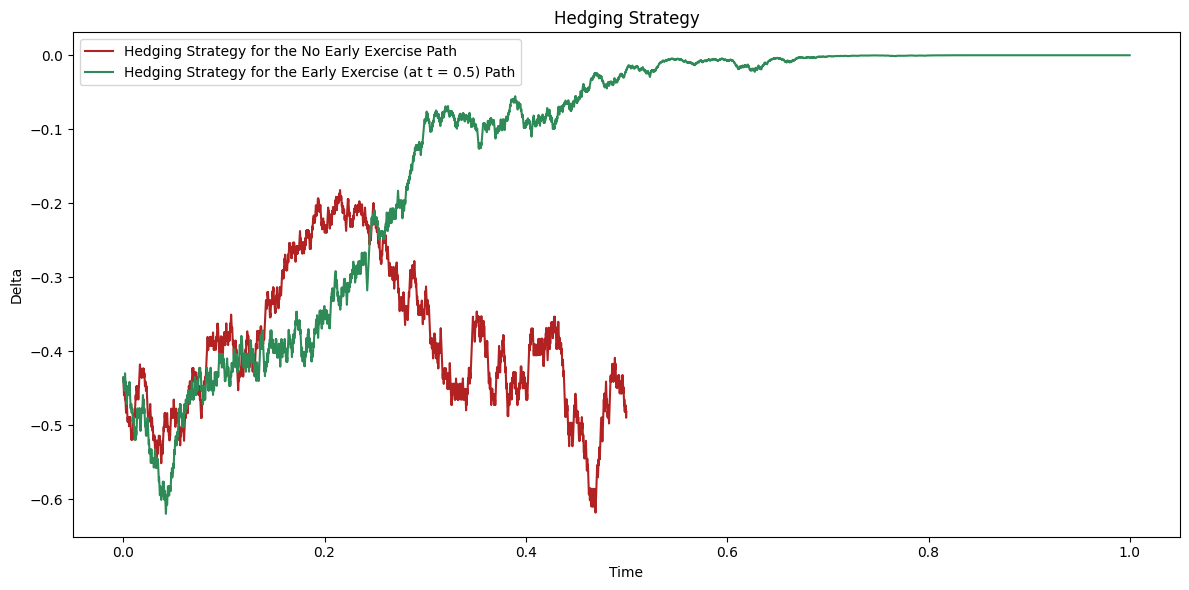

In [11]:
def generate_sample_paths(S0, u, d, p, dt, N=5000):

    # Path 1: Exercise early at t = 0.5
    path1, path2 = [S0], [S0]
    current_price = S0

    for i in range(N):
        if i == N // 2:  # Simulate early exercise at t = 0.5
            break

        if np.random.rand() < p:
            current_price *= u
        else:
            current_price *= d
        path1.append(current_price)

    # Path 2: Hold until maturity
    current_price = S0
    for i in range(N):
        if np.random.rand() < p:
            current_price *= u
        else:
            current_price *= d
        path2.append(current_price)

    return path1, path2


def delta_hedge(path, V, S):
    time_steps = np.arange(len(path))

    # broadcasting
    stock_indices = np.argmin(np.abs(S[time_steps, :len(path)] - path[:, None]), axis=1)
    S_up = S[time_steps[1:], stock_indices[:len(path) - 1]]
    S_down = S[time_steps[1:], stock_indices[:len(path) - 1] + 1]

    V_up = V[time_steps[1:], stock_indices[:len(path) - 1]]
    V_down = V[time_steps[1:], stock_indices[:len(path) - 1] + 1]

    # deltas
    delta = np.where(S_up != S_down, (V_up - V_down) / (S_up - S_down), 0)

    return delta

def plot_paths_and_hedging(S0, K, T, r, sigma, N=5000, mu = 0.05):

    dt = T / N

    # Up and down factors (u and d)
    u = np.exp(r * dt + sigma * np.sqrt(dt))
    d = np.exp(r * dt - sigma * np.sqrt(dt))

    # Risk-neutral up-branch probability
    p_risk_neutral = (1 - np.exp(-sigma * np.sqrt(dt))) / (
        np.exp(sigma * np.sqrt(dt)) - np.exp(-sigma * np.sqrt(dt))
    )

    # Physical measure probability of an up move
    p = 0.5 * (1 + ((mu - r) - 0.5 * sigma**2) / sigma * np.sqrt(dt))

    path1, path2 = generate_sample_paths(S0, u, d, p, dt, N)

    S, V = plot_exercise_boundary(sigma=sigma, r=r, ax=None, just_stock_option_tree=True)

    # Get deltas
    deltas1 = delta_hedge(np.array(path1), V, S)
    deltas2 = delta_hedge(np.array(path2), V, S)

    times = np.linspace(0, T, N+1)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot hedging
    ax.plot(times[:len(deltas1)], deltas1, label='Hedging Strategy for the No Early Exercise Path', color="firebrick")
    ax.plot(times[:len(deltas2)], deltas2, label='Hedging Strategy for the Early Exercise (at t = 0.5) Path', color="seagreen")
    ax.set_title("Hedging Strategy")
    ax.set_xlabel("Time")
    ax.set_ylabel("Delta")
    ax.legend()

    plt.tight_layout()
    plt.show()

np.random.seed(0)
plot_paths_and_hedging(S0=10, K=10, T=1, r=0.02, sigma=0.2, N=5000)

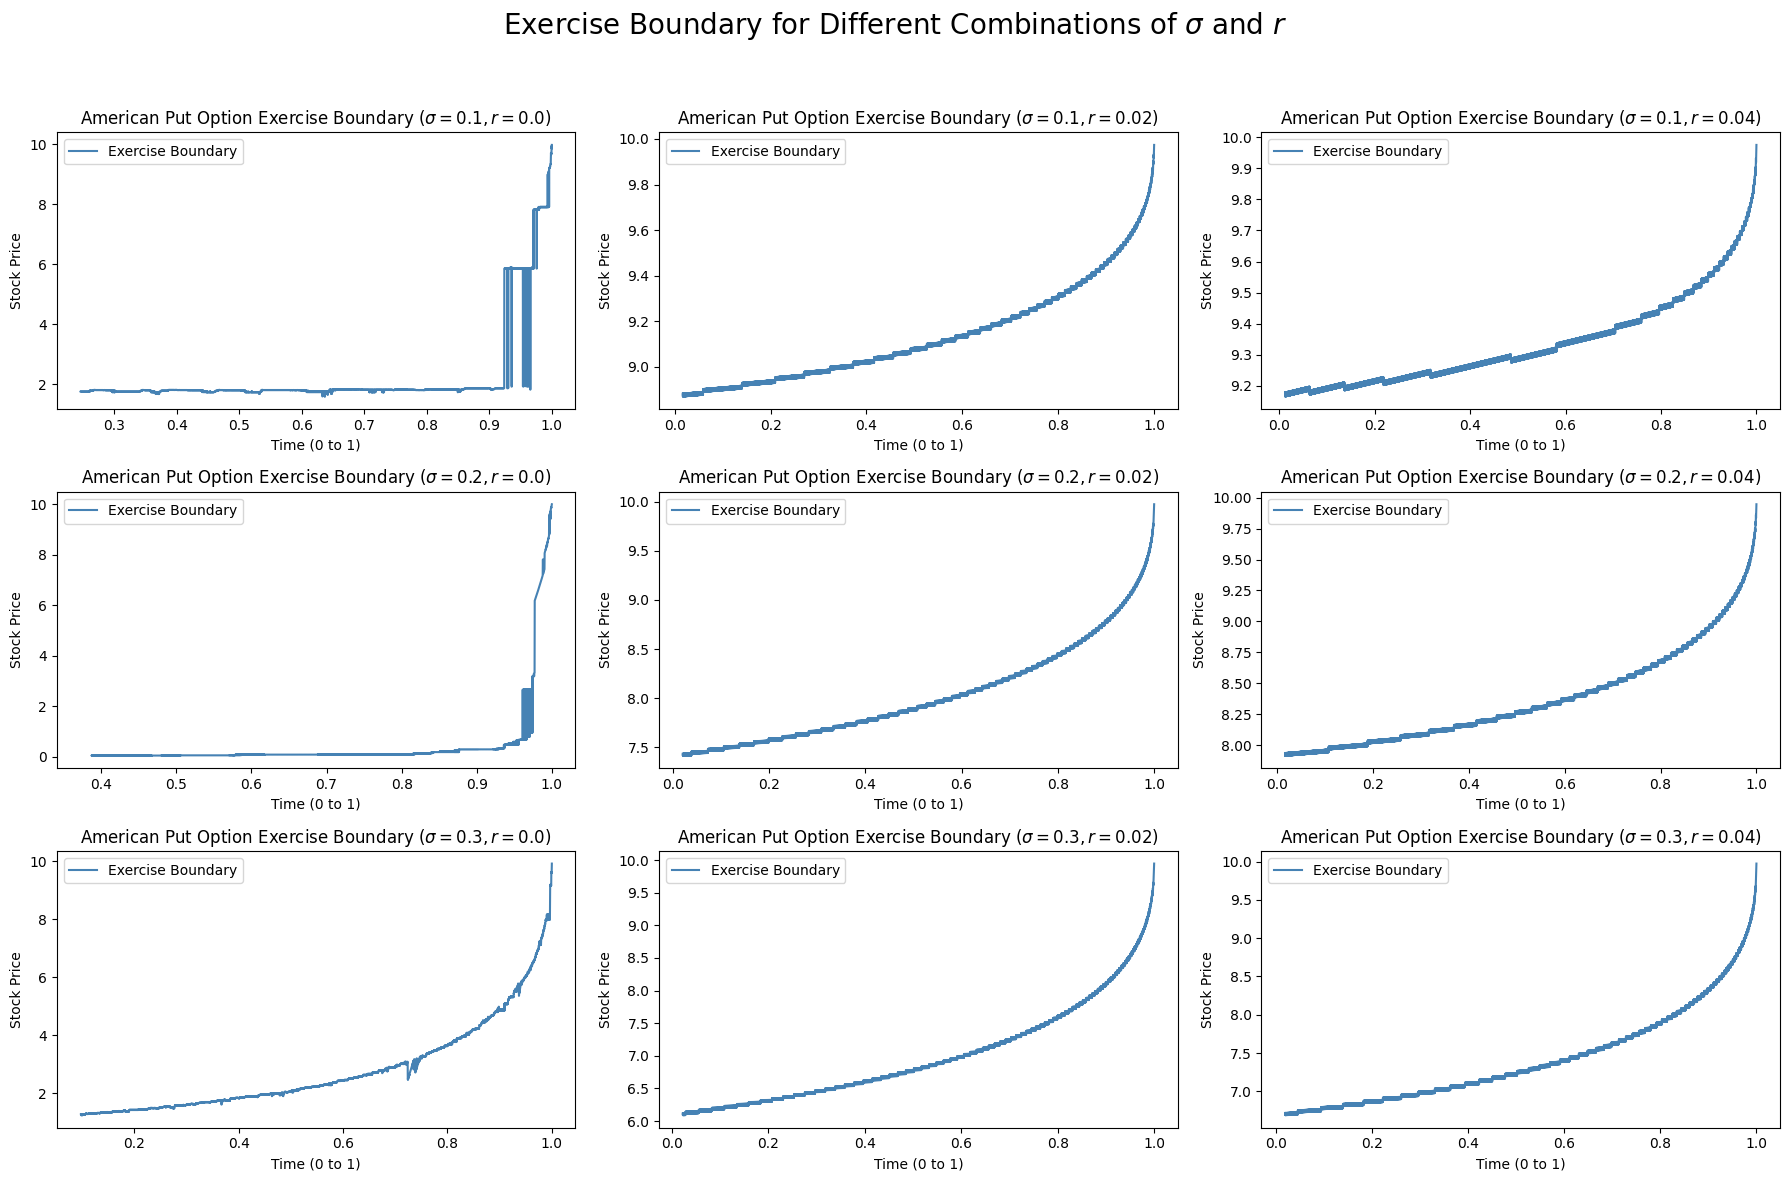

In [12]:
sigma_values = [0.10, 0.20, 0.30]  # 10%, 20%, 30%
r_values = [0.00, 0.02, 0.04]      # 0%, 2%, 4%

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Exercise Boundary for Different Combinations of $\sigma$ and $r$", fontsize=20)

for i, sigma in enumerate(sigma_values):
    for j, r in enumerate(r_values):
        ax = axes[i, j]
        plot_exercise_boundary(sigma, r, ax=ax)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

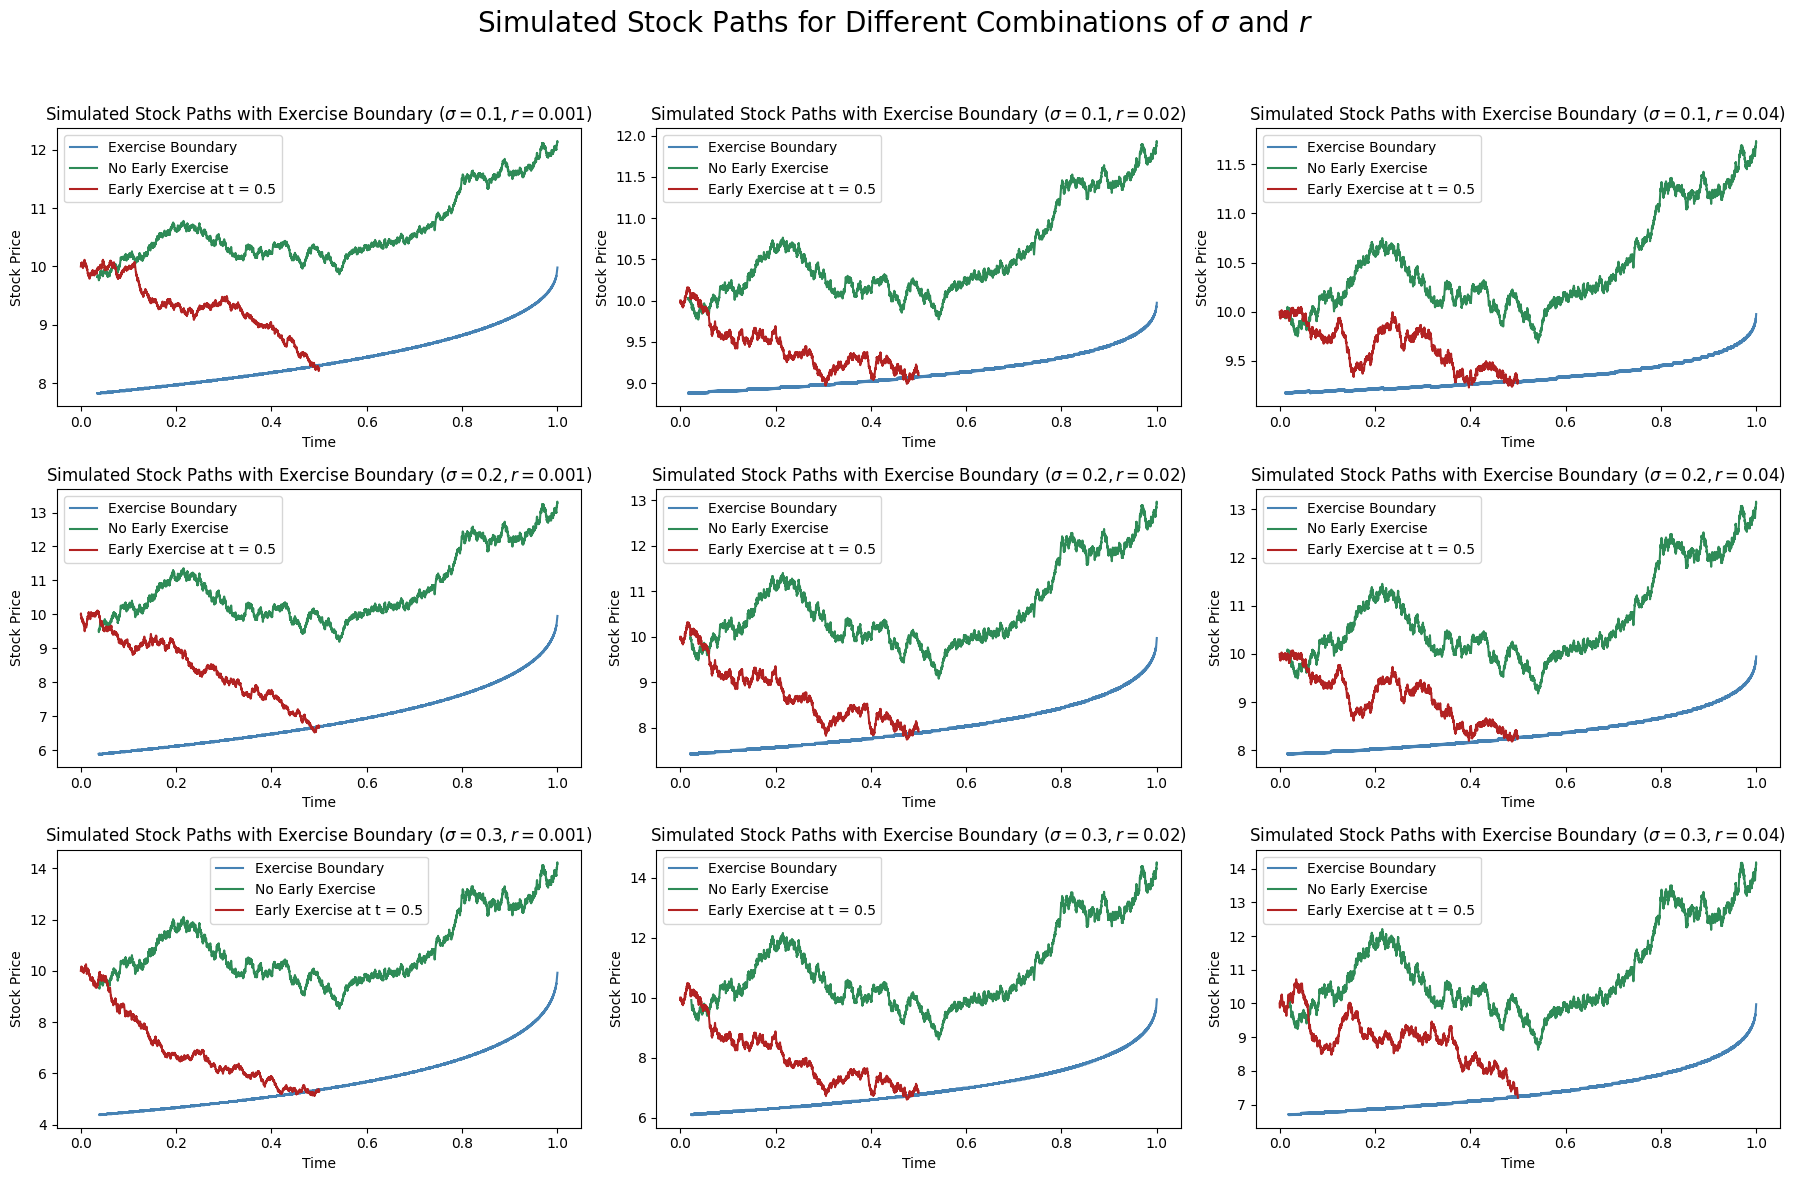

In [9]:
sigma_values = [0.1, 0.2, 0.3]  # 10%, 20%, 30%
r_values = [0.001, 0.02, 0.04]      # 0.01%, 2%, 4%

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("Simulated Stock Paths for Different Combinations of $\sigma$ and $r$", fontsize=20)

for i, sigma in enumerate(sigma_values):
    for j, r in enumerate(r_values):
        ax = axes[i, j]
        np.random.seed(0)
        generate_paths_with_exercise_boundary(sigma=sigma, r=r, ax=ax, T=1, S0=10, K=10, mu=0.05, N=5000)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

